In [1]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from model import ResNeXt, Discriminator
from dataloader import get_dataloaders

# Seed
manual_seed = 0
random.seed(manual_seed)
torch.manual_seed(manual_seed)
torch.use_deterministic_algorithms(True)

train_dataloader, test_dataloader = get_dataloaders()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


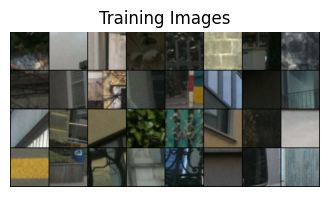

In [5]:
phone, dslr = next(iter(train_dataloader))
phone_tensor = np.reshape(phone, [-1, 3, 100, 100])
plt.figure(figsize=(4,4))
plt.axis("off")
plt.title("Training Images")
# display the images with shape of torch.Size([3, 100, 100, 32])
plt.imshow(np.transpose(vutils.make_grid(phone_tensor), (1,2,0)))

In [20]:
phone_img.shape

torch.Size([32, 3, 100, 100])